In [1]:
import numpy as np
import pylab as pb
import GPy
import copy as cp

import pickle

import matplotlib as mpl

from cassL import camb_interface as ci
from cassL import generate_emu_data as ged
from cassL import user_interface as ui

pb.ion()

file_base = ""

In [3]:
X_raw = np.load("G_versions/hc_G6_test.npy", allow_pickle=True)
Y_raw = np.load("G_versions/samples_G6_test.npy", allow_pickle=True)
# Emulator version label, for plots
emu_vlabel = "G7b"

In [4]:
scales = np.load("standard_k.npy", allow_pickle=True)

In [5]:
def is_bad(row):
    if float('-inf') in row or float('inf') in row \
        or None in row or True in np.isnan(pspec) \
        or 0 in row:
        return True
    return False

bad_row_indices = []
for i in range(len(Y_raw)):
    pspec = Y_raw[i]
    if is_bad(pspec):
        bad_row_indices.append(i)

X = np.delete(X_raw, bad_row_indices, 0)
Y = np.delete(Y_raw, bad_row_indices, 0)

In [7]:
m = pickle.load(open("G_versions/analyses/massive_emulator_" + emu_vlabel + ".nucomet", "rb"))

In [8]:
def inverse_ytransform(raw_prediction):
    return np.exp(raw_prediction * m.ystdev + m.ymu)

In [9]:
par_ranges = ui.get_param_ranges(massive_neutrinos=True)
xmin = np.array([])
xrange = np.array([])

for key in par_ranges.keys():
    xmin = np.append(xmin, par_ranges[key][0])
    xrange = np.append(xrange, par_ranges[key][1] - par_ranges[key][0])

# ! This is bad form, xmin and xrange should be saved with the emulator object
def xtransform(configuration):
    return (configuration - xmin) / xrange

In [10]:
def nest(array):
    return np.array([np.array(array)])

In [11]:
preds = np.zeros(Y.shape)
rel_errors = np.zeros(Y.shape)
sq_errors = np.zeros(Y.shape)

for i in range(len(X)):
    x = xtransform(nest(X[i]))
    raw_pred, _ = m.predict(x)
    preds[i] = inverse_ytransform(raw_pred)
    rel_errors[i] = (preds[i] - Y[i]) / Y[i]
    sq_errors[i] = np.square(preds[i] - Y[i])

In [12]:
print("Squared error across all models:")
print(sum(sum(sq_errors)))

Squared error across all models:
211272581.6056066


[2.15785750e-02 1.36177000e-01 9.73865000e-01 8.32239993e-01
 2.56269744e-09 6.73700000e-03]


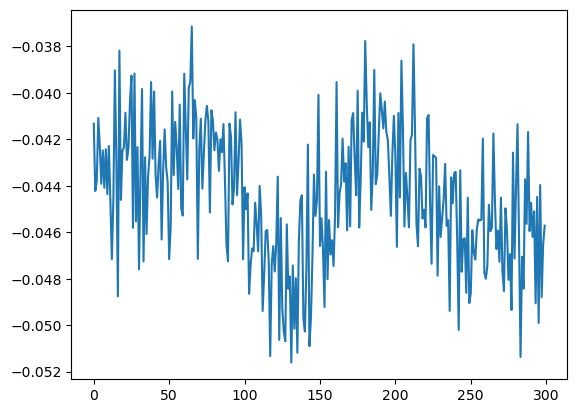

In [13]:
# An example of an extreme error plot, with the cosmology it was
# supposed to describe. 

pb.plot(rel_errors[900] * 100)
print(X[900])

In [14]:
min(X[:, 3])

0.20008000060333042

In [15]:
max(X[:, 3])

0.9999201620474477

In [16]:
def normalize(array):
    min_ = min(array)
    max_ = max(array)
    range_ = max_ - min_
    shifted = array - min_
    return shifted / range_

In [19]:
# Let's use the plasma color map
def plot_colored_errors(param_index, param_label, save_label=None):
    normalized_vals = normalize(X[:, param_index])
    colors = pb.cm.plasma(normalized_vals)

    for i in range(len(rel_errors)):
        if i % 1 == 0:
            pb.plot(scales, 100 * rel_errors[i],
                color=colors[i], alpha=0.05)
            pb.xscale('log')

    pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models" + 
            "\ncolored by " + param_label + " value")
    pb.ylabel("% error between CAMB and CassL")
    pb.xlabel("scale $k$ [1 / Mpc]")
    norm = mpl.colors.Normalize(
        vmin=min(X[:, param_index]), vmax=max(X[:, param_index]))
    pb.colorbar(mpl.cm.ScalarMappable(cmap=pb.cm.plasma, norm=norm))
    # Momentarily eliminate saving so that we don't keep crashing on the
    # incomplete file handles.
    if save_label is not None:
        pb.savefig("../plots/emulator/performance/" + save_label + ".png")

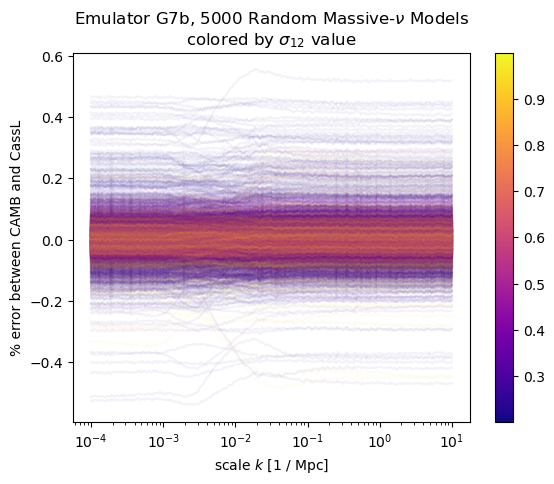

In [20]:
plot_colored_errors(3, r"$\sigma_{12}$", save_label="s12_coloration")

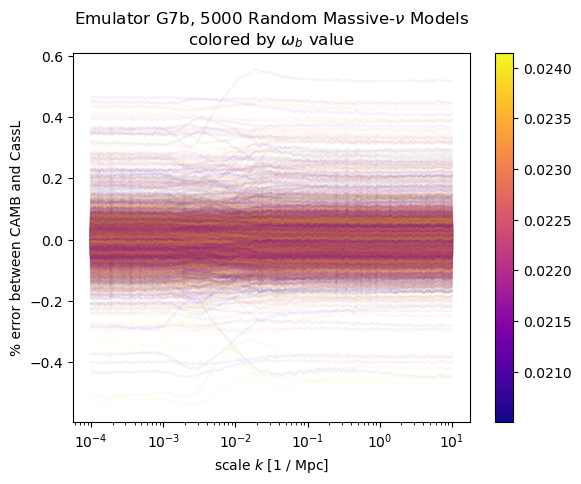

In [21]:
plot_colored_errors(0, r"$\omega_b$")

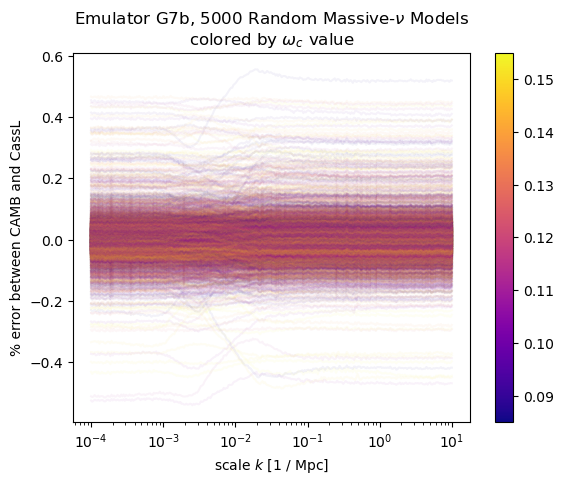

In [22]:
plot_colored_errors(1, r"$\omega_c$")

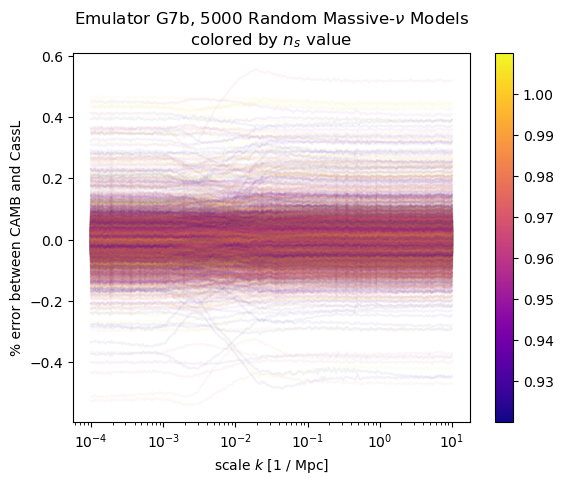

In [23]:
plot_colored_errors(2, r"$n_s$")

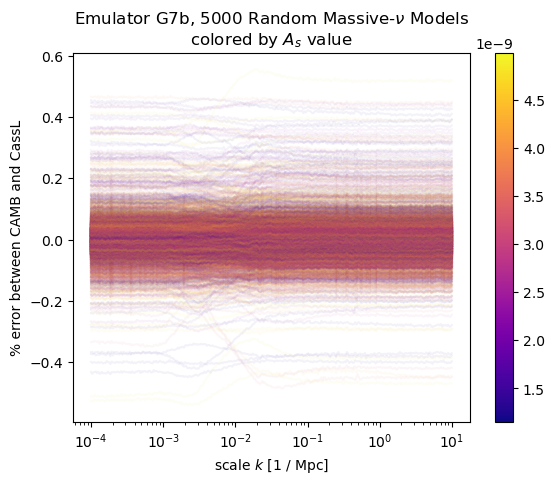

In [24]:
plot_colored_errors(4, r"$A_s$", "_colored_by_As")

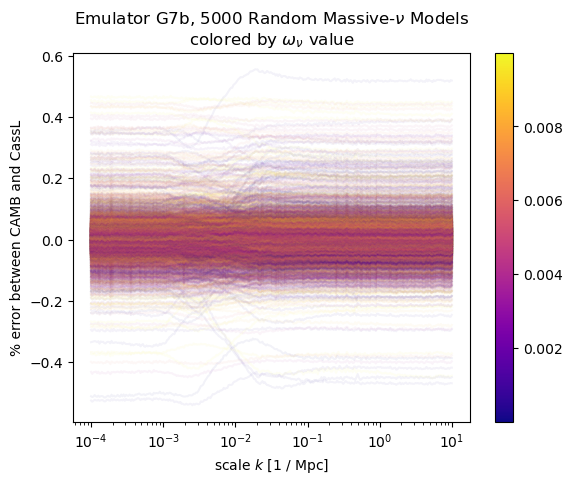

In [25]:
plot_colored_errors(5, r"$\omega_\nu$", "_colored_by_omnu")

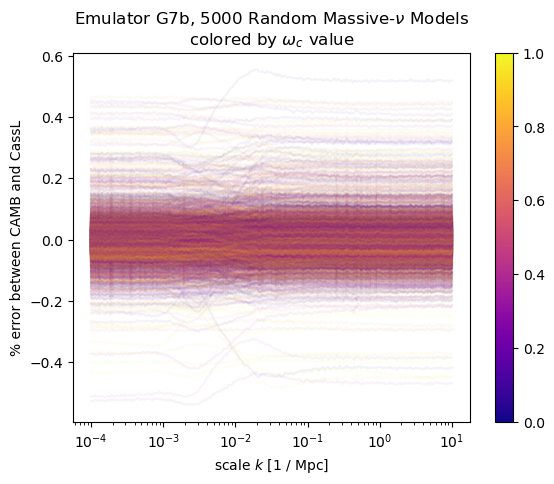

In [26]:
# This cell is wrong, right? It must be a leftover... it doesn't seem to have
# anything that the already-correct solution above lacks...

# Let's use the plasma color map
normalized_omc_vals = normalize(X[:, 1])
colors_omc = pb.cm.plasma(normalized_omc_vals)

for i in range(len(rel_errors)):
    if i % 1 == 0:
        pb.plot(scales, 100 * rel_errors[i],
            color=colors_omc[i], alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models" "\n" 
        r"colored by $\omega_c$ value")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
pb.colorbar(mpl.cm.ScalarMappable(cmap=pb.cm.plasma))
#pb.savefig("../plots/emulator/performance/massive_5k_G6.png")

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

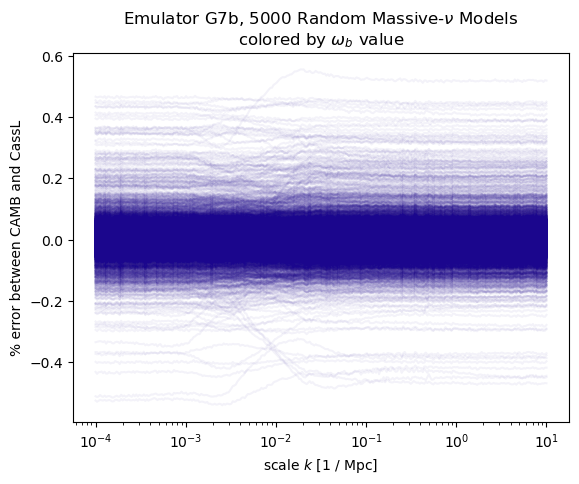

In [27]:
# This cell is wrong, right? It must be a leftover... it doesn't seem to have
# anything that the already-correct solution above lacks...

for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales, 100 * rel_errors[i],
            color=pb.cm.plasma(X[i][0]), alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models" "\n" 
        r"colored by $\omega_b$ value")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

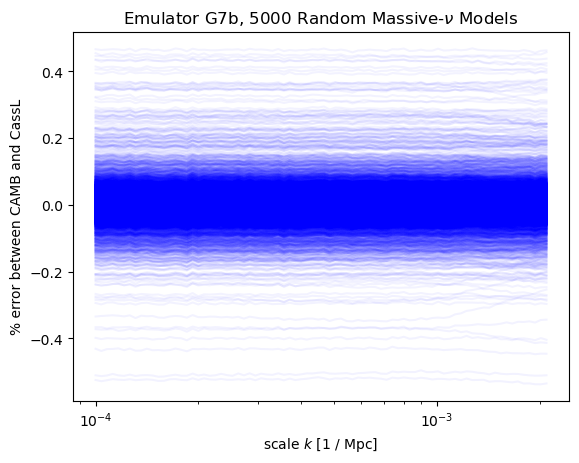

In [28]:
for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales[:80], 100 * rel_errors[i][:80],
            color='blue', alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
#pb.savefig("../plots/emulator/performance/massive_5k_G6.png")

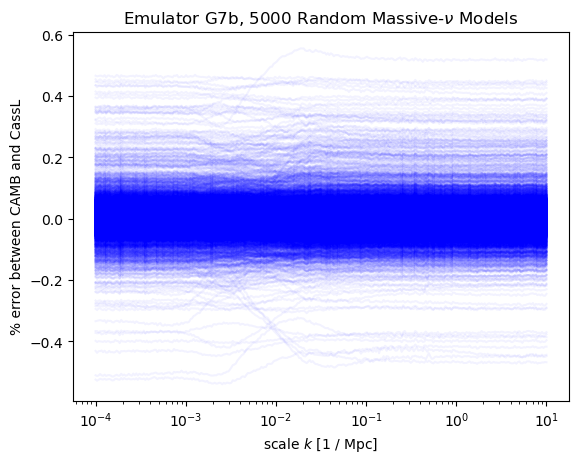

In [30]:
for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales, 100 * rel_errors[i],
            color='blue', alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
pb.savefig("../plots/emulator/performance/massive_5k_G7a.png")

In [31]:
# Error statistics ideas: parentheticals describe building blocks

# (for each curve:)
    # a minimum percent error
    # b maximum percent error
    # c standard deviation of errors
    # d mean error
    # e median error

# Median, mean, stddev of a-e.

mins = np.array([min(abs(rel_error_curve)) for rel_error_curve in rel_errors])
print("MINIMUM RELATIVE ERRORS:")
print("this ranges from", min(mins), "to", max(mins))
print("median is", np.median(mins))
print("mean is", np.mean(mins))
print("st.dev. is", np.std(mins))

MINIMUM RELATIVE ERRORS:
this ranges from 7.068266488286185e-10 to 0.0044138536431408025
median is 0.00016691982816454542
mean is 0.0002835327578125796
st.dev. is 0.0004192782920521625


In [32]:
maxs = np.array([max(abs(rel_error_curve)) for rel_error_curve in rel_errors])
print("MAXIMUM RELATIVE ERRORS:")
print("this ranges from", min(maxs), "to", max(maxs))
print("median is", np.median(maxs))
print("mean is", np.mean(maxs))
print("st.dev. is", np.std(maxs))

MAXIMUM RELATIVE ERRORS:
this ranges from 7.002998638443235e-05 to 0.005550343482264292
median is 0.0004284584899318524
mean is 0.0005561232212191425
st.dev. is 0.0005006180914037113


In [33]:
means = np.array([np.mean(rel_error_curve) for rel_error_curve in rel_errors])
print("MEAN RELATIVE ERRORS:")
print("this ranges from", min(means), "to", max(means))
print("median is", np.median(means))
print("mean is", np.mean(means))
print("st.dev. is", np.std(means))

MEAN RELATIVE ERRORS:
this ranges from -0.004835677304700841 to 0.004618039121579369
median is 1.2424457667361347e-05
mean is 2.1412796113708232e-05
st.dev. is 0.0006175784881701272


In [34]:
meds = np.array([np.median(rel_error_curve) for rel_error_curve in rel_errors])
print("MEDIAN RELATIVE ERRORS:")
print("this ranges from", min(meds), "to", max(meds))
print("median is", np.median(meds))
print("mean is", np.mean(meds))
print("st.dev. is", np.std(meds))

MEDIAN RELATIVE ERRORS:
this ranges from -0.0046937924018831435 to 0.005161215624826814
median is 1.2393228155901171e-05
mean is 2.2951140646038477e-05
st.dev. is 0.0006303736610734948


In [35]:
stddevs = np.array([np.std(rel_error_curve) for rel_error_curve in rel_errors])
print("ST.DEV.S IN RELATIVE ERRORS:")
print("this ranges from", min(stddevs), "to", max(stddevs))
print("median is", np.median(stddevs))
print("mean is", np.mean(stddevs))
print("st.dev. is", np.std(stddevs))

ST.DEV.S IN RELATIVE ERRORS:
this ranges from 2.11918897752691e-05 to 0.0013547217696736687
median is 4.87179785385899e-05
mean is 7.251766347306305e-05
st.dev. is 8.369588916581212e-05


(array([4048.,  635.,  192.,   49.,   32.,   17.,    7.,    9.,    5.,
           6.]),
 array([7.06826649e-10, 4.41386000e-04, 8.82771294e-04, 1.32415659e-03,
        1.76554188e-03, 2.20692717e-03, 2.64831247e-03, 3.08969776e-03,
        3.53108306e-03, 3.97246835e-03, 4.41385364e-03]),
 <BarContainer object of 10 artists>)

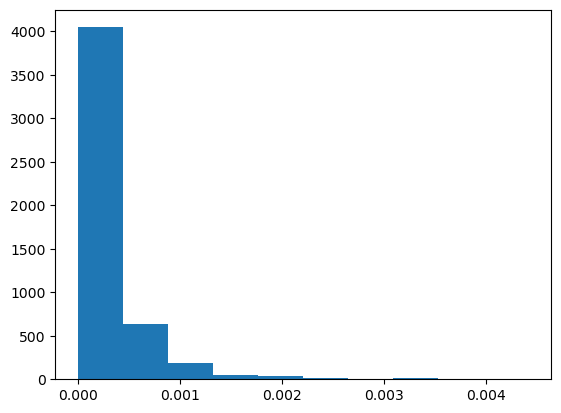

In [36]:
pb.hist(mins)

(array([3.649e+03, 9.580e+02, 2.350e+02, 8.000e+01, 3.300e+01, 1.500e+01,
        1.100e+01, 8.000e+00, 8.000e+00, 3.000e+00]),
 array([7.00299864e-05, 6.18061336e-04, 1.16609269e-03, 1.71412404e-03,
        2.26215538e-03, 2.81018673e-03, 3.35821808e-03, 3.90624943e-03,
        4.45428078e-03, 5.00231213e-03, 5.55034348e-03]),
 <BarContainer object of 10 artists>)

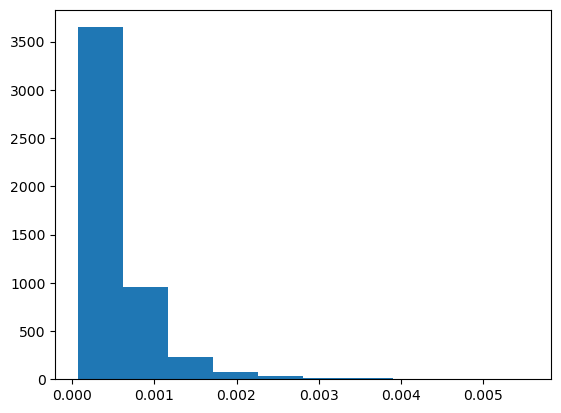

In [37]:
pb.hist(maxs)

(array([4.618e+03, 2.680e+02, 6.000e+01, 2.300e+01, 1.400e+01, 7.000e+00,
        5.000e+00, 3.000e+00, 1.000e+00, 1.000e+00]),
 array([2.11918898e-05, 1.54544878e-04, 2.87897866e-04, 4.21250854e-04,
        5.54603842e-04, 6.87956830e-04, 8.21309818e-04, 9.54662806e-04,
        1.08801579e-03, 1.22136878e-03, 1.35472177e-03]),
 <BarContainer object of 10 artists>)

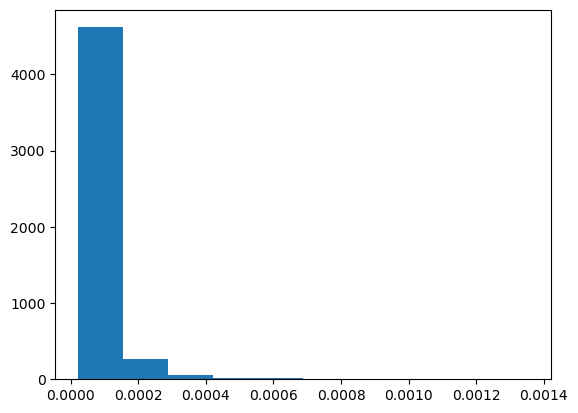

In [38]:
pb.hist(stddevs)

(array([   7.,    4.,   20.,  300., 3084., 1446.,   90.,   31.,   12.,
           6.]),
 array([-0.00469379, -0.00370829, -0.00272279, -0.00173729, -0.00075179,
         0.00023371,  0.00121921,  0.00220471,  0.00319021,  0.00417571,
         0.00516122]),
 <BarContainer object of 10 artists>)

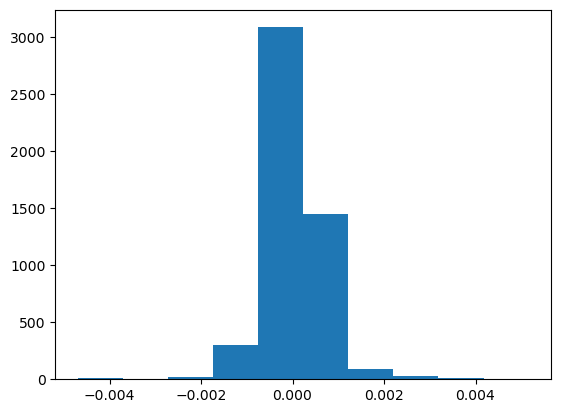

In [39]:
pb.hist(meds)

(array([   4.,    4.,   11.,  145., 1829., 2758.,  181.,   42.,   17.,
           9.]),
 array([-0.00483568, -0.00389031, -0.00294493, -0.00199956, -0.00105419,
        -0.00010882,  0.00083655,  0.00178192,  0.0027273 ,  0.00367267,
         0.00461804]),
 <BarContainer object of 10 artists>)

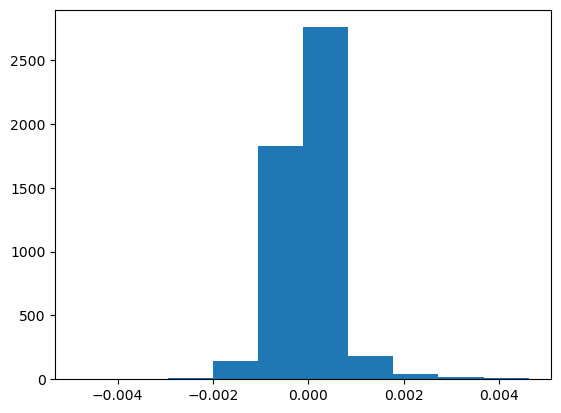

In [40]:
pb.hist(means)